In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [20]:
train_horses = tf.data.Dataset.list_files(str('horse2zebra/trainA/*'))   #读取训练集普通马图像路径
train_zebras = tf.data.Dataset.list_files(str('horse2zebra/trainB/*'))   #读取训练集斑马图像路径
test_horses = tf.data.Dataset.list_files(str('horse2zebra/testA/*'))   #读取测试集普通马图像路径
test_zebras = tf.data.Dataset.list_files(str('horse2zebra/testB/*'))   #读取测试集斑马图像路径

In [21]:
batch_size = 8   #批大小
img_width = 128   #预处理后的图像宽
img_height = 128   #预处理后的图像长

In [22]:
for i in train_horses.take(5):   #查看其中5张图像路径
    print(i.numpy())

b'horse2zebra\\trainA\\n02381460_105.jpg'
b'horse2zebra\\trainA\\n02381460_757.jpg'
b'horse2zebra\\trainA\\n02381460_863.jpg'
b'horse2zebra\\trainA\\n02381460_255.jpg'
b'horse2zebra\\trainA\\n02381460_235.jpg'


In [23]:
def decode2img(img):   #解码成图像格式
    img = tf.image.decode_jpeg(img, channels=3)   #解码成RGB格式图片
    img = tf.image.resize(img, [img_height, img_width])   #修改图像尺寸
    return img   
def process(file_path):
    img = tf.io.read_file(file_path)   #读取图片，返回字符串tensor
    img = decode2img(img)   #解码输出成图像格式
    img = (img/127.5)-1   #图像归一化
    return img

In [24]:
#将图像处理函数映射至训练集和测试集中
train_horses = train_horses.map(process, num_parallel_calls=tf.data.experimental.AUTOTUNE)   
train_zebras = train_zebras.map(process, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_horses = test_horses.map(process, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_zebras = test_zebras.map(process, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [25]:
def configure_dataset(dataset):   #数据集配置
    dataset = dataset.shuffle(buffer_size=1000)   #打乱
    dataset = dataset.batch(batch_size)   #分批
    return dataset

train_horses = configure_dataset(train_horses)
train_zebras = configure_dataset(train_zebras)
test_horses = configure_dataset(test_horses)
test_zebras = configure_dataset(test_zebras)

In [26]:
print(train_horses)

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>


In [27]:
sample_horse = next(iter(train_horses))   #遍历一张普通马图像
sample_zebra = next(iter(train_zebras))   #遍历一张斑马图像

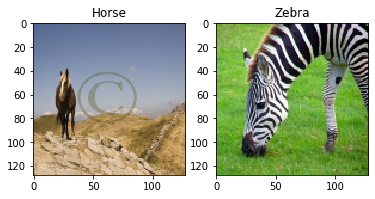

In [28]:
#查看遍历的图像
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)
plt.subplot(122)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

In [29]:
#实例归一化
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [30]:
def downsample(filters, size):  #下采样单元模块
    result = tf.keras.Sequential()   #顺序式搭建
    #卷积层
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False))
    result.add(InstanceNormalization())   #实例归一化层
    result.add(tf.keras.layers.LeakyReLU())   #激活函数
    return result

In [31]:
def upsample(filters, size):   #上采样单元模块
    result = tf.keras.Sequential()   #顺序式搭建
    #反卷积层
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(0., 0.02),use_bias=False))
    result.add(InstanceNormalization())   #实例归一化层
    result.add(tf.keras.layers.Dropout(0.5))   #dropout层
    result.add(tf.keras.layers.ReLU())   #激活函数
    return result

In [42]:
def unet_generator(output_channels):   #生成器
    down_stack = [   #下采样路径
      downsample(64, 4), 
      downsample(128, 4),  
      downsample(256, 4),  
      downsample(512, 4), 
      downsample(512, 4),  
      downsample(512, 4),  
      downsample(512, 4),  
    ]
    up_stack = [   #上采样路径
      upsample(512, 4), 
      upsample(512, 4),  
      upsample(512, 4), 
      upsample(512, 4),  
      upsample(256, 4), 
      upsample(128, 4),  
      upsample(64, 4),  
    ]

    last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(0., 0.02),activation='tanh')
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs
    skips = []   #用于存储跳跃连接层
    for down in down_stack:   #遍历下采样路径模块
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])   #翻转存储跳跃连接层的数组
    for up, skip in zip(up_stack, skips):   #遍历上采样路径模块和存储跳跃连接层的数组
        x = up(x)
        x = concat([x, skip])   #跳跃连接
    x = last(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)   #对模型输入输出进行拼接
    return model

In [50]:
def discriminator():   #判别器结构
    input = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')   #输入图像
    x = input
    #下采样路径
    down1 = downsample(64, 4)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2)  
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)   #零填充  
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer = tf.random_normal_initializer(0., 0.02),use_bias=False)(zero_pad1) 
    norm = InstanceNormalization()(conv)   #实例归一化
    leaky_relu = tf.keras.layers.LeakyReLU()(norm)   #激活函数
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  
    last = tf.keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=tf.random_normal_initializer(0., 0.02))(zero_pad2)   #输出1维的判别值
    model = tf.keras.Model(inputs=input, outputs=last)   #对模型输入输出进行拼接
    return model   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


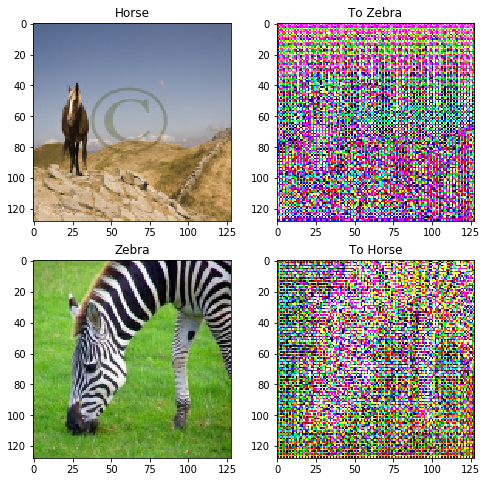

In [65]:
generator_g = unet_generator(3)   #调用生成器
generator_f = unet_generator(3)
discriminator_x = discriminator()   #调用判别器
discriminator_y = discriminator()

to_zebra = generator_g(sample_horse)   #生成马转斑马
to_horse = generator_f(sample_zebra)   #生成斑马转马 
plt.figure(figsize=(8, 8))
imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']
for i in range(len(imgs)):   #显示转换结果
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * 8 + 0.5)
plt.show()

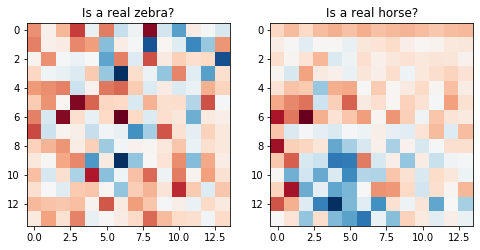

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')   #查看斑马判别器结果
plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')   #查看马判别器结果
plt.show()

In [66]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [67]:
def discriminator_loss(real, generated):   #判别器损失
    real_loss = loss(tf.ones_like(real), real)   #真输入为1
    generated_loss = loss(tf.zeros_like(generated), generated)   #假输入为0
    total_disc_loss = real_loss + generated_loss   #总损失
    return total_disc_loss * 0.5

In [57]:
def generator_loss(generated):   #生成器损失
    return loss(tf.ones_like(generated), generated)

In [68]:
def calc_cycle_loss(real_image, cycled_image):   #G(y->x)和G(x->y)的损失函数
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss1

In [59]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [60]:
EPOCHS = 40

In [61]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)   #优化器配置
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [62]:
def generate_images(model, test_input):   #查看生成的图片
    prediction = model(test_input)   #模型预测
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]   #测试输入和预测结果
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [70]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)   #真输入x，生成假y
        cycled_x = generator_f(fake_y, training=True)   #假输入y，还原x
        fake_x = generator_f(real_y, training=True)   #真输入y，生成假x
        cycled_y = generator_g(fake_x, training=True)   #假输入x，还原y
        same_x = generator_f(real_x, training=True)   #真输入x，输出同样的x
        same_y = generator_g(real_y, training=True)   #真输入y，输出同样的y
        disc_real_x = discriminator_x(real_x, training=True)   #判别真输入x
        disc_real_y = discriminator_y(real_y, training=True)   #判别真输入y
        disc_fake_x = discriminator_x(fake_x, training=True)   #判别假输入x
        disc_fake_y = discriminator_y(fake_y, training=True)   #判别假输入y
        #计算生成器和判别器损失
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    #计算生成器和判别器的梯度
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    #对生成器和判别器的梯度进行更新
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

In [ ]:
for epoch in range(40):
    n = 0
    #读取马和斑马图像
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
    clear_output(wait=True)
    generate_images(generator_g, sample_horse)   #查看生成图像